In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
base_image_path = "ucsd.jpg"
style_reference_image_path = "vango.jpg"

total_variation_weight = 1.0
style_weight = 1.0 
content_weight = 0.025 / 400

width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = 400#int(width * img_nrows / height)

In [3]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) 
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, 3, img_nrows, img_ncols))

In [4]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [5]:
def get_loss2(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred#vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    print K.shape(base_image_features)
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features, combination_features)
#     loss = 0 * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
#     loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [32]:
# Combine generative layer with VGG layer
inputs = Input(shape=( img_nrows*img_nrows*3, ))

# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*img_nrows*img_nrows / 16, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((64, img_nrows / 4, img_nrows / 4))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(64, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)
x = Convolution2D(64, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

In [33]:
# jpgfile = Image.open("vango2.jpg")
# inp = np.array(jpgfile.getdata())
# inp = np.reshape(inp, (3, -1))
# inpY = 1.0 * np.reshape(inp, (1, 3, img_nrows, img_nrows)) 


jpgfile = Image.open("vango2.jpg")
inp = np.array(base_image.eval())
trainX = np.reshape(inp, (1, 3, img_nrows, img_ncols))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
# print np.product(trainX.shape)
# trainX3 = np.random.rand(1, 150528)
# trainX3 = trainX3[:, :3]
# inpY = inpY/256.0

In [34]:
inpY = np.asarray(base_image.eval())

In [35]:
print trainX3.shape
print inpY.shape
print generative_model.summary()


(1, 480000)
(1, 3, 400, 400)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 480000)        0                                            
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 5)             2400005     input_7[0][0]                    
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 640000)        3840000     dense_7[0][0]                    
____________________________________________________________________________________________________
batchnormalization_4 (BatchNormal(None, 640000)        1280000     dense_8[0][0]                    
______________________________________________________________

In [36]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(loss = get_loss2, optimizer = adam_op)

Model loaded.
Shape.0


0
(3, 400, 400)


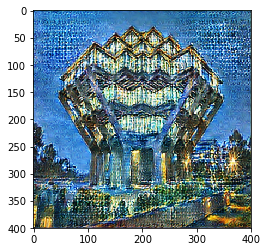

1
(3, 400, 400)


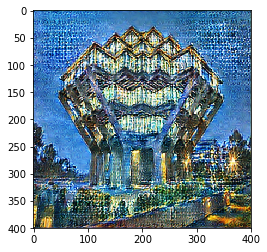

2
(3, 400, 400)


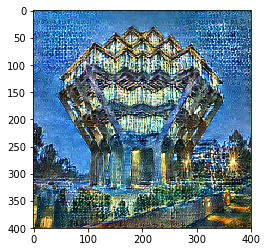

3
(3, 400, 400)


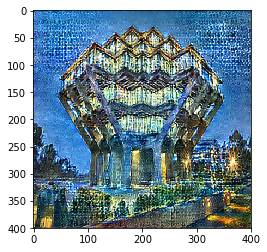

4
(3, 400, 400)


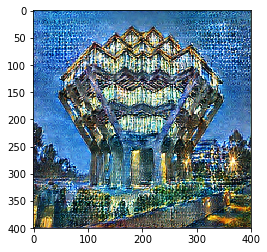

5
(3, 400, 400)


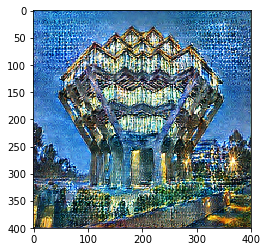

6
(3, 400, 400)


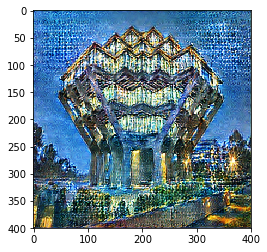

7
(3, 400, 400)


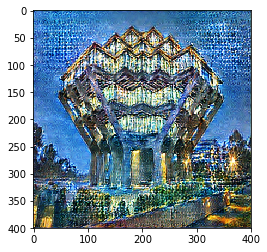

8
(3, 400, 400)


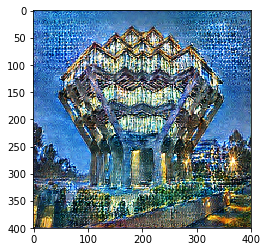

9
(3, 400, 400)


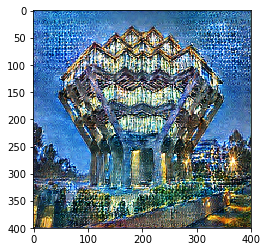

In [38]:
for i in range(10):
    generative_model.fit(trainX3, inpY, nb_epoch = 100, verbose=0)
    print i
    img = generative_model.predict(trainX3)
    img = img[0]
    print img.shape
    img = img.swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img)
    plt.show()

In [18]:
jpgfile = Image.open("orig.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

150528


In [19]:
# generative_model.fit(trainX3, inpY, nb_epoch = 10)
img = generative_model.predict(trainX3)
img = img[0]
print img.shape
img = img.swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(img)
# plt.savefig('styletsfr.jpg')
plt.show()

Exception: Error when checking : expected input_3 to have shape (None, 480000) but got array with shape (1, 150528)